# DRILLING PERMITS PROJECT

## Predicting the approval time for drilling permits in the state of Texas

## Brian Clements

### 01/24/2022

## Project Description

This Jupyter Notebook and presentation explore public records relating to oil and gas permitting in the State of Texas. The data used include all of the permits that were approved from the beginning of 2016 to the end of 2021.  Apart from a general exploration of the data and potential relationships, the hope is to make a predictive model on one or more continuous variables, such as well depth, type of bore, and particularly, the amount of time a permit is approved.

I will use Residual Mean Square Error as my metric for evaluation; many models will be built using different features and hyperparameters to find the model of best fit.  One of the final deliverables will be the RMSE value resulting from my best model, contrasted with the baseline RMSE.

Additionally, a Jupyter Notebook with my main findings and conclusions will be a key deliverable; many .py files will exist as a back-up to the main Notebook (think "under-the-hood" coding that will facilitate the presentation).

## Project Goals

The ultimate goal of this project is to build a model that predicts amount of time a permit takes to be approved; however, there is considerable doubt as to the potential predictive power of such a model, and this goal may shift as my data exploration evolves. An equally important goal, then, is a thorough exploration of the data in search of any relationship that might be found.

## Executive Summary

All oil and gas drilling in the State of Texas is regulated by the Texas Railroad Commission (TRRC); in the name of transparency and equitable, speedy, and efficient public service, it's important that this body be held accountable to its responsibilities.  

This study has done an exhaustive exploration of public data relating to permitting done by the TRRC, and has found that permitting is generally being done quickly across all of the TRRC's districts; in all the counties of the state; and in all the shale formations, with few exceptions.

The study has gone as far as to build a machine learning regression model in an attempt to predict the approval time for permits; while the model was able to beat the baseline prediction by a very modest 6/10ths of 1 percent, it served mainly to drive home the point that the TRRC drilling permit times are roughly the same, no matter how one looks at the data.

To put it another way: "there isn't much to see here."

In [1]:
# the imports required for this notebook
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import sklearn.linear_model
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

import wrangle_module
import model
import viz
import hypothesis_testing

In [2]:
# acquire and prep using functions in my wrangle_module
permits = wrangle_module.acquire_permits()
permits = wrangle_module.prep_permits(permits)
# permits = wrangle_module.encode_permits(permits)
permits.shape

(67355, 15)

In [3]:
permits.head()

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,Current_Queue,Permit_submitted,Approval_time_days,SHALE,Depth_bin
Permit_approved,,,,,,,,,,,,,,,
2016-01-04,28531642,"CANTERA OPERATING, LLC (129692)",O. A. LAMPLEY GU 1,1,02,LAVACA,Vertical,Recompletion,N,13606,APPROVED,2016-01-04,0,EAGLE FORD,Deep
2016-01-04,46140267,"PARSLEY ENERGY OPERATIONS, LLC (642652)",RATLIFF 28,1D,7C,UPTON,Vertical,New Drill,N,6000,APPROVED,2015-12-31,4,PERMIAN BASIN,Shallow
2016-01-04,30132834,RKI EXPLORATION & PRODUCTION LLC (714221),CBR 4,6H,08,LOVING,Horizontal,New Drill,N,16000,APPROVED,2015-12-31,4,PERMIAN BASIN,Deep
2016-01-04,44331348,HENRY RESOURCES LLC (378535),LAUREN,6201,7C,TERRELL,Vertical,Recompletion,N,12500,APPROVED,2016-01-04,0,PERMIAN BASIN,Deep
2016-01-04,28335696,CABOT OIL & GAS CORPORATION (121700),"SCHORP-WHITE RANCH, LTD. 12H",12H,01,LA SALLE,Horizontal,New Drill,N,8500,APPROVED,2015-12-30,5,EAGLE FORD,Shallow


In [4]:
# double check the datatype on the index
type(permits.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# get info on the attributes
permits.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67355 entries, 2016-01-04 to 2021-12-30
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   API_NO.               67355 non-null  int64         
 1   Operator_Name_Number  67355 non-null  object        
 2   Lease_Name            67355 non-null  object        
 3   Well                  67355 non-null  object        
 4   District              67355 non-null  object        
 5   County                67355 non-null  object        
 6   Wellbore_Profile      67355 non-null  object        
 7   Filing_Purpose        67355 non-null  object        
 8   Amend                 67355 non-null  object        
 9   Total_Depth           67355 non-null  int64         
 10  Current_Queue         67355 non-null  object        
 11  Permit_submitted      67355 non-null  datetime64[ns]
 12  Approval_time_days    67355 non-null  int64         
 13 

- Approval_time is an object, should be datetime or integer/float

In [6]:
# description method for numerical data in the df
permits.describe()

,API_NO.,Total_Depth,Approval_time_days
count,6.735500e+04,67355.000000,67355.000000
mean,2.928214e+07,9899.913384,6.572088
std,1.303898e+07,3814.741387,5.653174
min,1.008200e+05,150.000000,0.000000
25%,2.113533e+07,7976.500000,2.000000
50%,3.173532e+07,10000.000000,5.000000
75%,3.893657e+07,12000.000000,9.000000
max,7.063026e+07,28010.000000,27.000000


In [7]:
# calculate the earliest and latest timestamps, and the difference between them
permits.index.min(), permits.index.max(), permits.index.max()-permits.index.min()

(Timestamp('2016-01-04 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timedelta('2187 days 00:00:00'))

- from the beginning of 2016 to the end of 2021

In [8]:
# checking approval status of all permits; they are all approved
permits.Current_Queue.value_counts()

APPROVED    67355
Name: Current_Queue, dtype: int64

- all rows are in approved status

In [9]:
# searching for nulls; there were initially a few that i addressed in wrangling
permits.isna().sum()

API_NO.                 0
Operator_Name_Number    0
Lease_Name              0
Well                    0
District                0
County                  0
Wellbore_Profile        0
Filing_Purpose          0
Amend                   0
Total_Depth             0
Current_Queue           0
Permit_submitted        0
Approval_time_days      0
SHALE                   0
Depth_bin               0
dtype: int64

- There are no nulls left after wrangling

In [10]:
# how many unique lease names?
permits.Lease_Name.nunique()

27177

- many duplicated lease names, but we are keeping these bc the same lease name can file multiple times for different wells/reasons

In [11]:
# counties and count of observations each
permits.County.value_counts()

REEVES        5627
MIDLAND       4883
MARTIN        4361
LOVING        3539
HOWARD        3364
              ... 
FLOYD            1
DEAF SMITH       1
KINNEY           1
MILLS            1
CORYELL          1
Name: County, Length: 219, dtype: int64

In [12]:
# number of counties represented

len(permits.County.unique())

219

- there are 219 texas counties represented in this data

In [13]:
permits.head(1)

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,Current_Queue,Permit_submitted,Approval_time_days,SHALE,Depth_bin
Permit_approved,,,,,,,,,,,,,,,
2016-01-04,28531642,"CANTERA OPERATING, LLC (129692)",O. A. LAMPLEY GU 1,1,02,LAVACA,Vertical,Recompletion,N,13606,APPROVED,2016-01-04,0,EAGLE FORD,Deep


array([[<AxesSubplot:title={'center':'API_NO.'}>,
        <AxesSubplot:title={'center':'Total_Depth'}>],
       [<AxesSubplot:title={'center':'Permit_submitted'}>,
        <AxesSubplot:title={'center':'Approval_time_days'}>]],
      dtype=object)

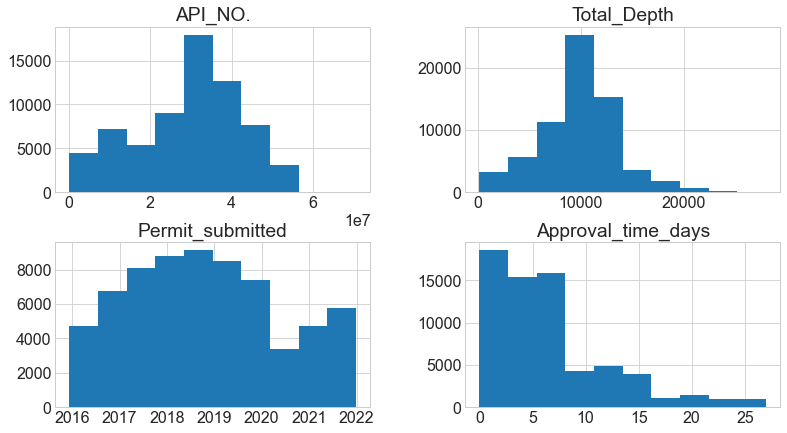

In [14]:
# draw distributions of numerical attributes
permits.hist()

- well depth is normally distributed
- notice a dropoff in permits in 2020--covid related downturn, for sure
- almost all approval times were a matter of a couple of days, with a couple of outliers
- the api number (a uniqe identifying number for every well) has a county component, which may explain why it doesn't seem completely random

<AxesSubplot:>

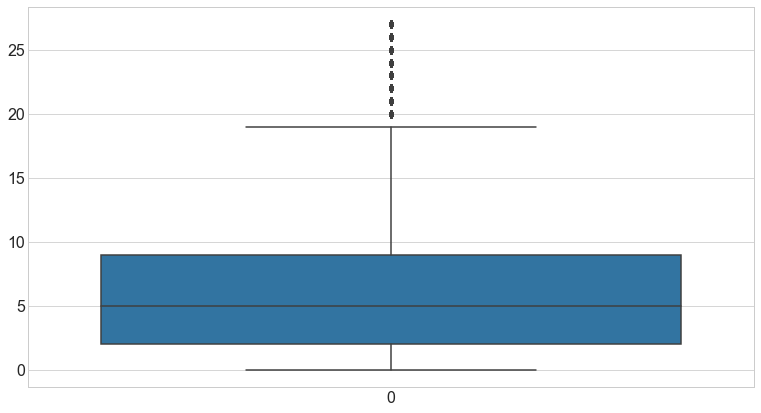

In [15]:
# a boxplot oof the approval time for all permits (many outliers were handled in wrangle)
sns.boxplot(data=permits.Approval_time_days)

- The distribution of approval times, including mean, iqrs and outliers

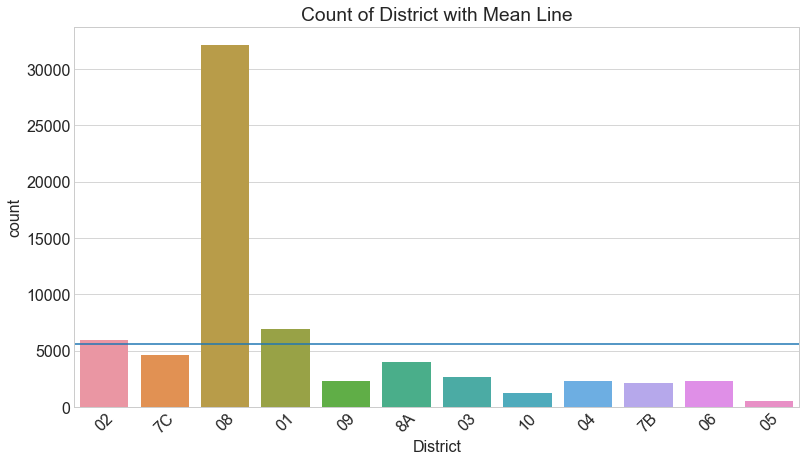

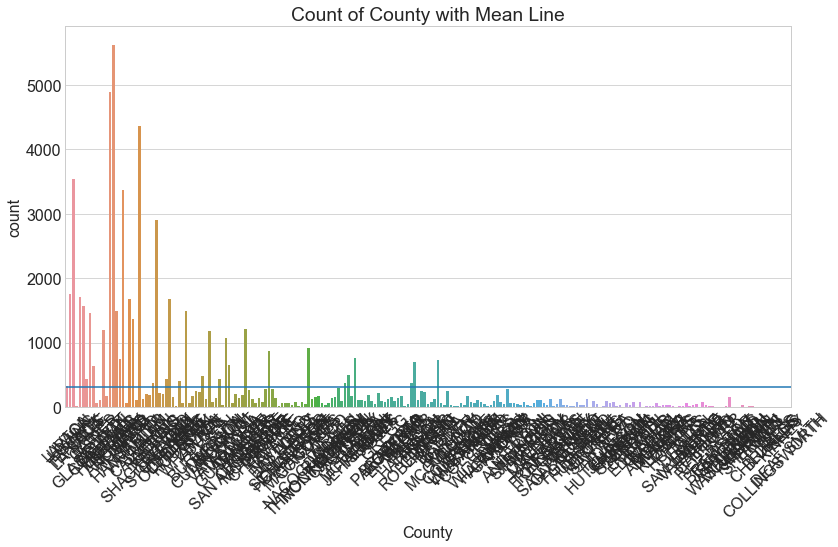

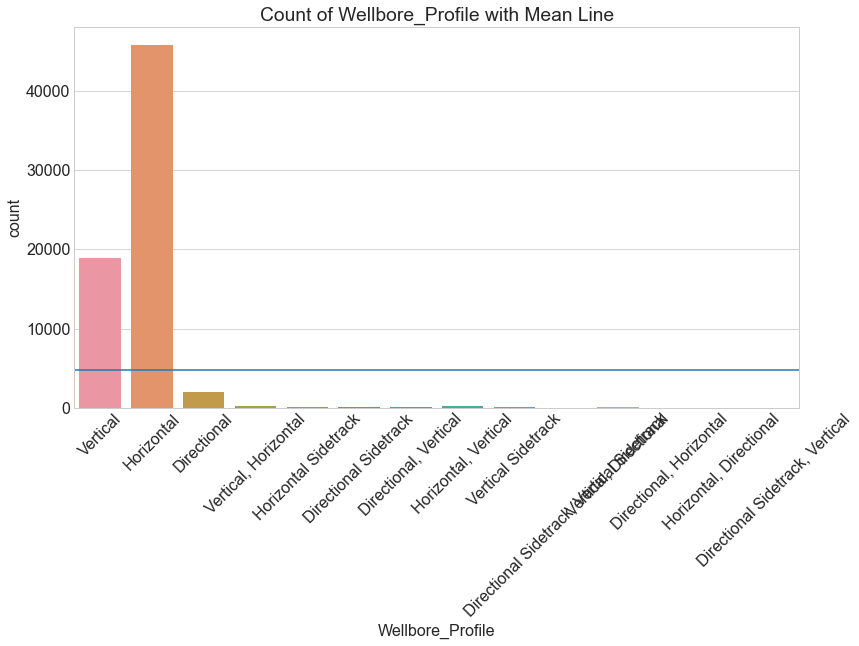

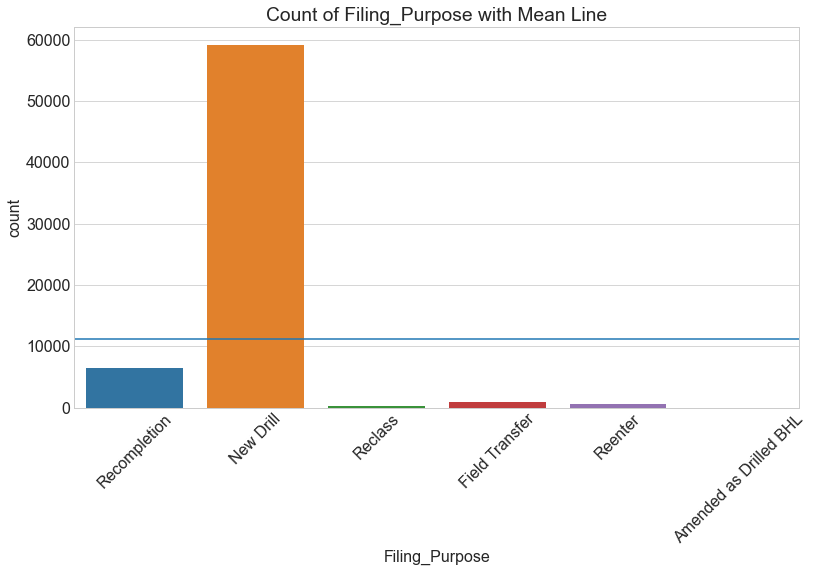

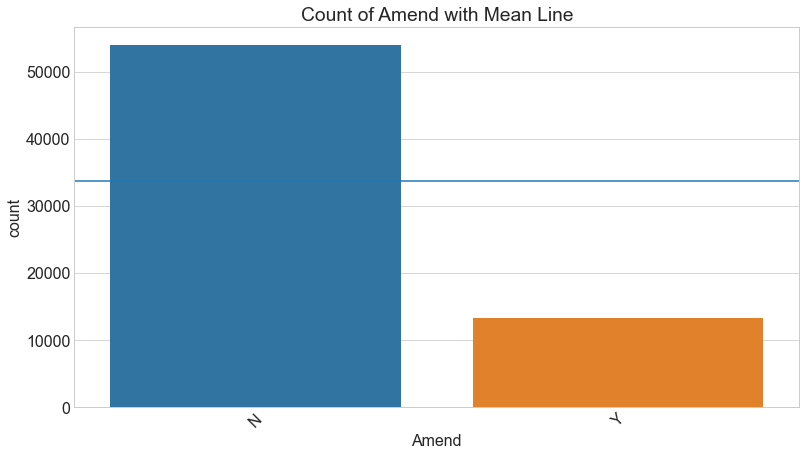

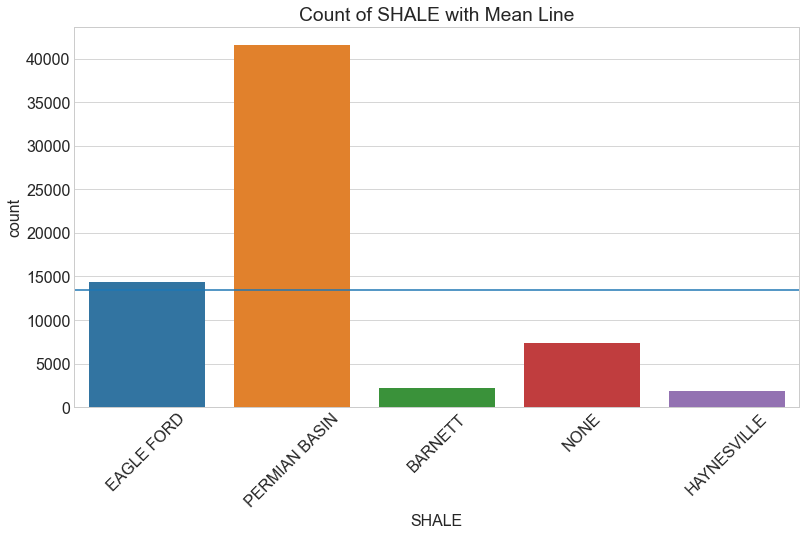

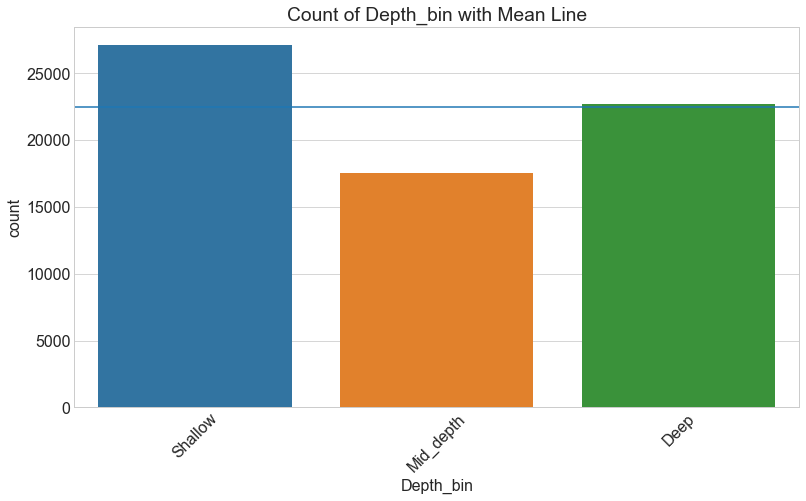

In [16]:
viz.counts_w_mean_lines(permits)

- District 8 is far and away the biggest for drilling permits
- There are six counties with considerably higher permitting--explore this more
- Horizontal wells are surprisingly the most common for permitting, followed by vertical.  Presumably due to the prevalence of fracking
- Almost everything is new drilling
- Relatively few ammended permits, but enough to take into account.
- The Permian is far and away the highest area for permitting, followed by the eagleford shale.  
- The three depth bins don't vary by far from the average, with 'Deep' being right about at average

In [17]:
# a list of the 6 counties with the most permit approvals
permits.County.value_counts().head(6)

REEVES     5627
MIDLAND    4883
MARTIN     4361
LOVING     3539
HOWARD     3364
KARNES     2903
Name: County, dtype: int64

### The top counties by permit requests:
- REEVES      5627
- MIDLAND     4883
- MARTIN      4361
- LOVING      3539
- HOWARD      3364
- KARNES      2903

<AxesSubplot:>

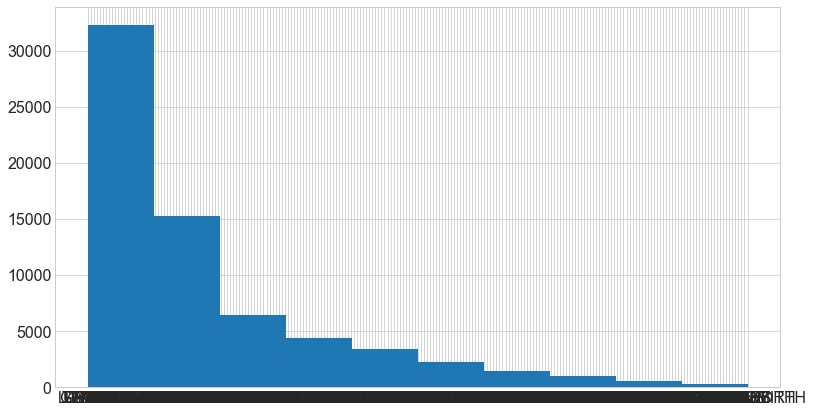

In [18]:
# the distribution of permit approvals by county. 
permits.County.hist()

- A few counties at the top occupy the vast majority of permit approvals

## Splitting , Encoding and Scaling the data here for further explo
- for the time being, i will not pursue the time series analysis perspective and will do a typical split, pending further exploration

In [19]:
# Encoding permits using the function in my wrangle module
permits = wrangle_module.encode_permits(permits)

In [20]:
# Creating splits for different uses later.  Also from my wrangle module
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = \
wrangle_module.split_permits(permits)


In [21]:
train.shape

(37718, 32)

In [22]:
train.head(1)

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,...,District_03,District_04,District_05,District_06,District_08,District_09,District_10,District_7B,District_7C,District_8A
Permit_approved,,,,,,,,,,,,,,,,,,,,,
2018-11-07,38937764,NOBLE ENERGY INC (611665),WILD BILL HICKOK 205-206 UNIT B,9H,08,REEVES,Horizontal,New Drill,N,13000,...,0,0,0,0,1,0,0,0,0,0


In [23]:
# Scaling my dfs; the y_ dfs were not actually scaled in this analysis, and so those
# dataframes are superfluous until removed at a later time.
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle_module.scale_permits(train,validate,test)

In [24]:
# using boolean masking to check the mean approval time for district 5
train[train.District == '05'].Approval_time_days.mean()

7.888178913738019

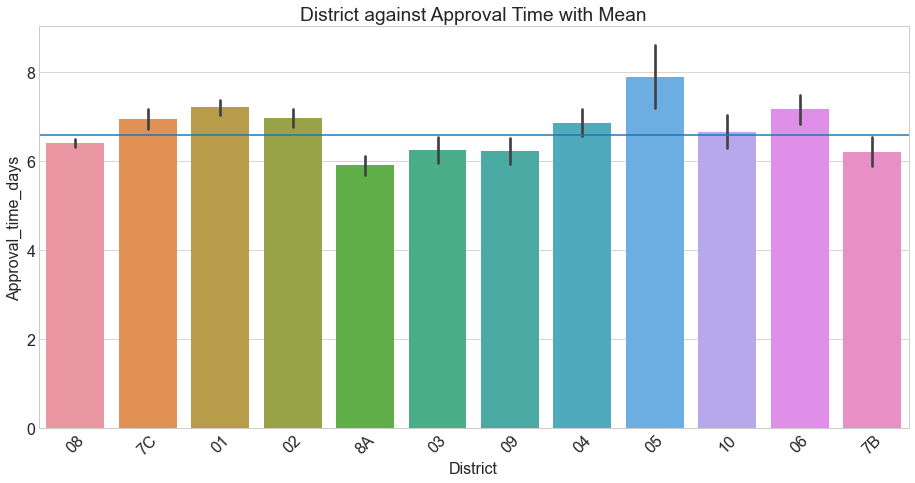

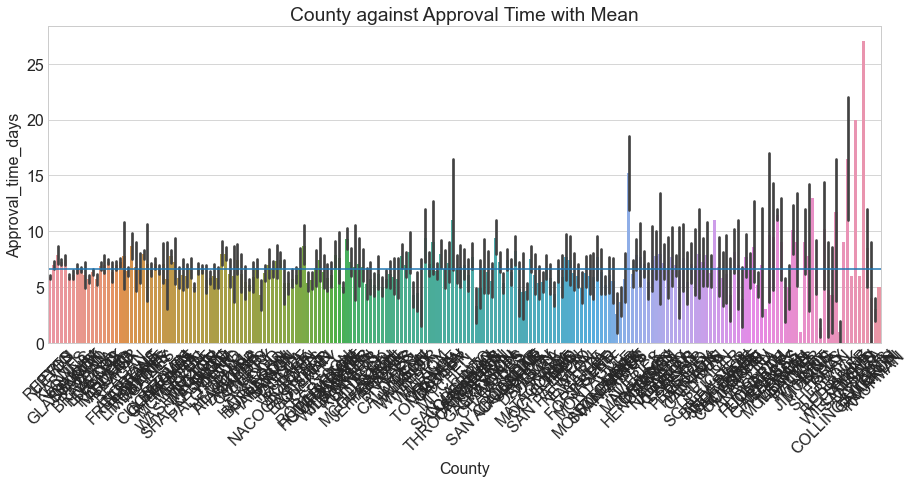

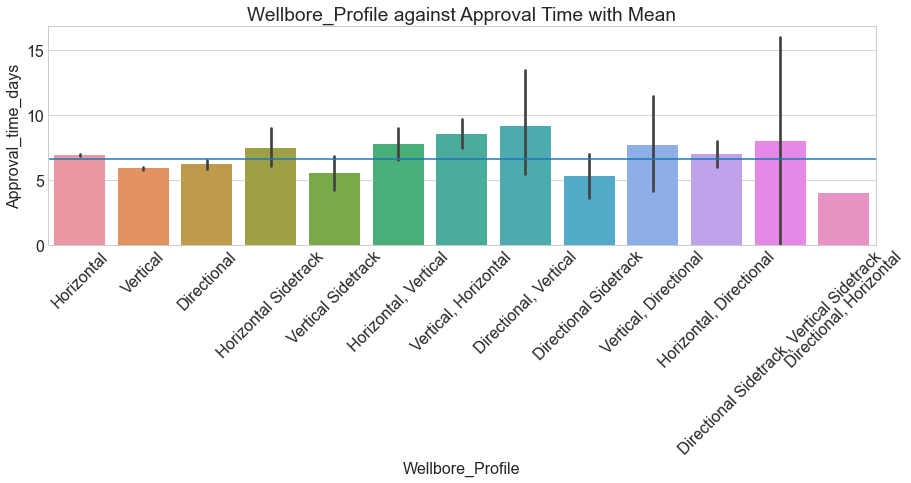

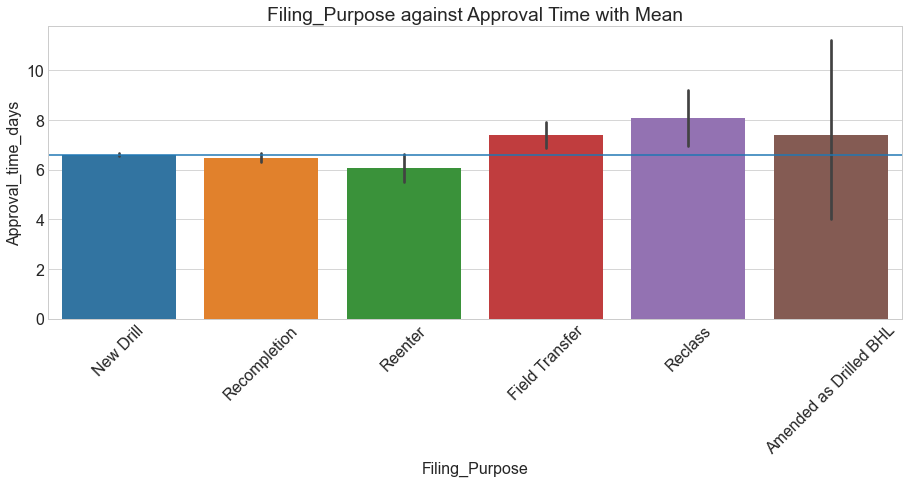

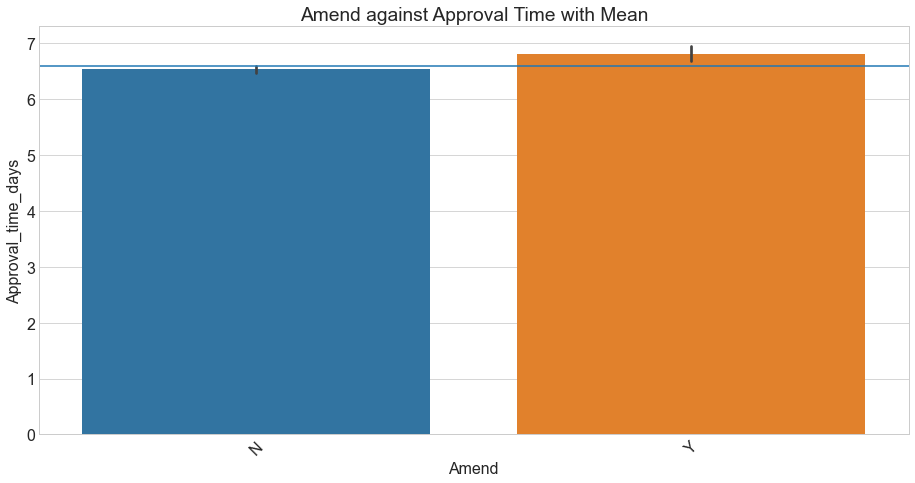

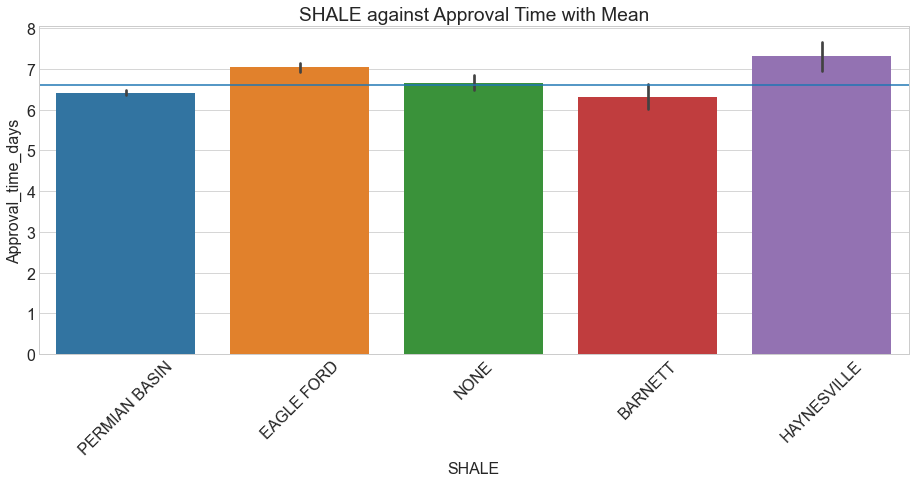

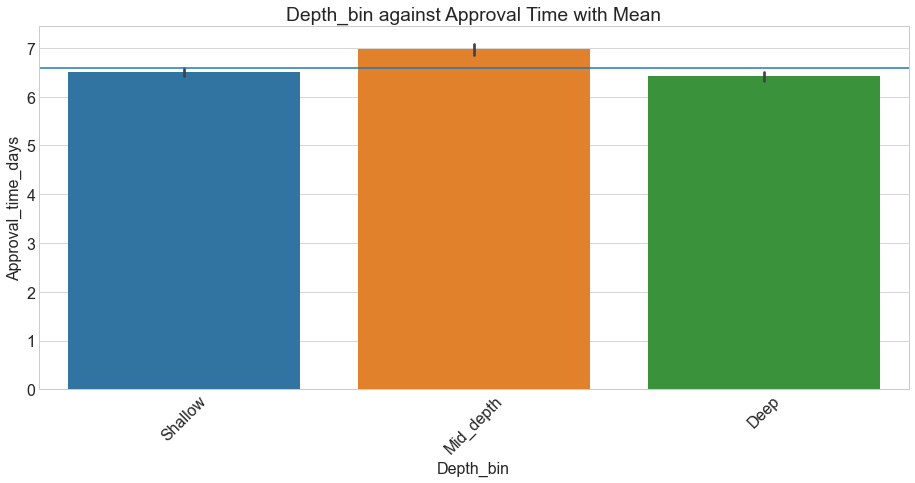

In [25]:
# funtion to plot discrete variables against approval time
viz.disrete_vs_approval_time(train)

- District 5 has a slightly higher approval time, but this would need to be shown with some statistical testing
- There are a few particularly slow counties for permitting, it would be interesting to isolate and explore these
- Filing purpose has virtually no relation to approval time, amend as well
- All shales have almost identical approval times; haynesville is a tiny bit more, but stats testing would be required to show this for sure
- Directional horizontal wells have a slightly shorter approval time. However, there are only three wellbore profiles with significant numbers: horizontal, vertical, and directional.  To the extent the rest might need to be dropped

In [26]:
# a boolean mask checking the number of observations with 'directional, horizontal'
# wellbore profile.  There are only two
train[train.Wellbore_Profile == 'Directional, Horizontal']

,API_NO.,Operator_Name_Number,Lease_Name,Well,District,County,Wellbore_Profile,Filing_Purpose,Amend,Total_Depth,...,District_04,District_05,District_06,District_08,District_09,District_10,District_7B,District_7C,District_8A,Depth_scaled
Permit_approved,,,,,,,,,,,,,,,,,,,,,
2018-10-29,25536206,ENCANA OIL & GAS(USA) INC. (251691),BURRIS UNIT,2H,02,KARNES,"Directional, Horizontal",New Drill,N,11000,...,0,0,0,0,0,0,0,0,0,0.389447


- There was only one 'Directional, Horizontal' permit approved in all the five years studied here

In [27]:
# a list of the number of observations for each wellbore profile
permits.Wellbore_Profile.value_counts()

Horizontal                                   45791
Vertical                                     18883
Directional                                   2014
Vertical, Horizontal                           182
Horizontal, Vertical                           163
Vertical Sidetrack                              86
Directional Sidetrack                           86
Horizontal Sidetrack                            84
Directional, Vertical                           31
Vertical, Directional                           25
Horizontal, Directional                          4
Directional, Horizontal                          3
Directional Sidetrack, Vertical Sidetrack        2
Directional Sidetrack, Vertical                  1
Name: Wellbore_Profile, dtype: int64

- Only 3 wellbore profiles dominate permit approvals: horizontal, vertical, and directional (which is by far the smallest of the three)

## Which counties are fastest/slowest for approvals?

In [28]:
# a list of counties with approval times above 15 days
len(train[train.Approval_time_days > 15].County.value_counts())

170

- 170 counties have average permitting times over 15 days

In [29]:
# The slowest 11 counties for average approval time, using a groupby and sorting, 
# displaying the last 11 only
train.groupby(by='County').Approval_time_days.mean().sort_values().tail(11)

County
DALLAS         10.153846
FALLS          10.200000
BREWSTER       11.000000
SAN JACINTO    11.000000
MCLENNAN       11.500000
RED RIVER      11.750000
HUNT           13.000000
TITUS          15.222222
SABINE         16.500000
FLOYD          20.000000
HOPKINS        27.000000
Name: Approval_time_days, dtype: float64

- The above is the list of 11 counties with mean approval times over ten days

In [30]:
# the same, but the other (fast) end of the list
train.groupby(by='County').Approval_time_days.mean().sort_values().head(11)

County
HILL          1.000000
WILLIAMSON    1.000000
SHERMAN       1.333333
HALE          2.600000
KAUFMAN       3.000000
CHILDRESS     3.000000
WALLER        3.300000
LAMB          3.653846
MENARD        3.857143
WILLACY       3.875000
FOARD         3.888889
Name: Approval_time_days, dtype: float64

- And the counties with a mean approval time less than 4 days

In [31]:
# defining a list of 'quick' counties for use below
quick_counties = \
['HILL',
'WILLIAMSON',
'SHERMAN',
'HALE', 
'KAUFMAN',
'CHILDRESS',
'WALLER',
'LAMB',  
'MENARD',
'WILLACY',
'FOARD']

In [32]:
# for loop returning the number of observations for each quick county
for county in quick_counties:
    print(len(train[train.County == county]))

2
3
6
10
2
1
20
26
7
8
9


- There are exceedingly few permit approvals for these counties on the top end of the approval times

In [33]:
# define list of slow counties
slow_counties = ['DALLAS', 'FALLS', 'BREWSTER', 'SAN JACINTO', 'MCLENNAN', 'RED RIVER',
       'HUNT', 'TITUS', 'SABINE', 'FLOYD', 'HOPKINS']

In [34]:
# number of observations for counties in the slow list
for county in slow_counties:
    print(len(train[train.County == county]))

13
5
1
7
4
4
2
9
2
1
1


- likewise, there are few observations in the slow counties

In [35]:
# in contrast, the number of observations for REEVES county
len(train[train.County == 'REEVES'])

3191

In [36]:
# and the average turnaround for REEVES county
train[train.County == 'REEVES'].Approval_time_days.mean()

5.9335631463491065

- The fastest and slowest counties have very few permits being approved every year, on average; as a counter-example, refer to Reeves county, with its 3191 permits over the period studied (and 5.93 day average approval time)
- The county attribute may problematic for modeling due to dimensionaliy issues

## Do deeper wells experience longer approval times?

<AxesSubplot:xlabel='Approval_time_days', ylabel='Total_Depth'>

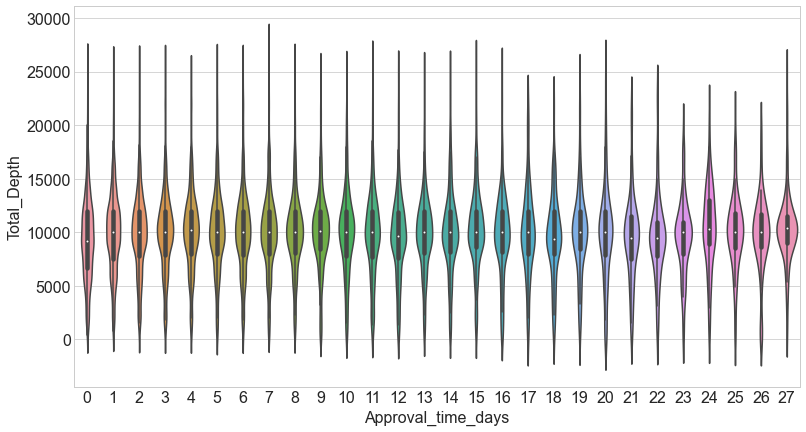

In [37]:
# violin plot of the well depth by approval time; 
# in this example, we're looking at approval time as a quasi-categorical value
sns.violinplot(data=train, y = 'Total_Depth', x = 'Approval_time_days')

- not a clear conclusion, this would be ripe for a levene then ANOVA test for differing variance

### Running a levene test to check on the variances between the populations above:

- H_0: The variances of the approval times by total depth are the same in all populations
- H_A: The variance in the populations is different

In [38]:
# self defined function to run a leven variance test on the above variables
hypothesis_testing.levene1(train)

LeveneResult(statistic=2.9291077993600134, pvalue=5.294306173499092e-07)

- the variances are not equal

### Kruskal-Wallace testing (since the variances are unequal):

- H_O: The population means for the different well depths (by approval time) is the same
- H_a: These population means are different

In [39]:
# set alpha, the confidence level i will use for stats tests in this notebook
alpha = .05

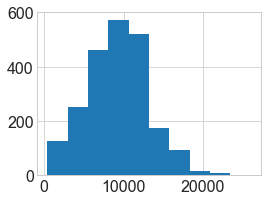

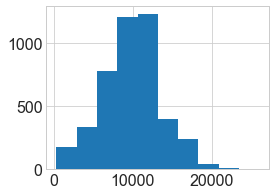

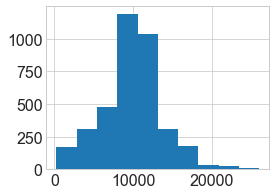

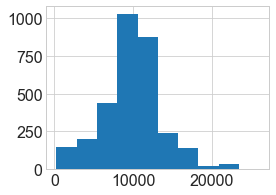

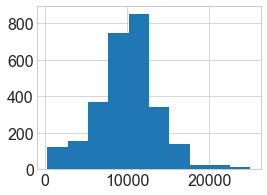

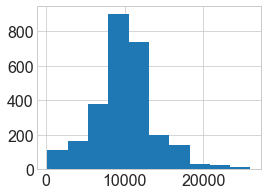

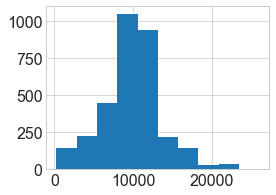

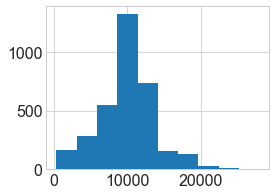

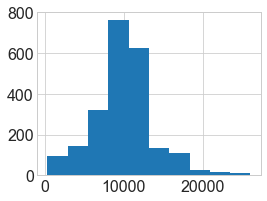

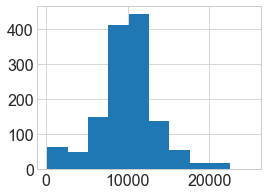

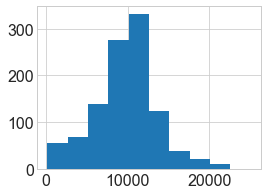

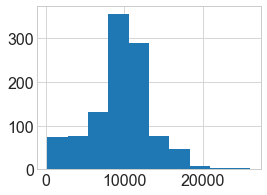

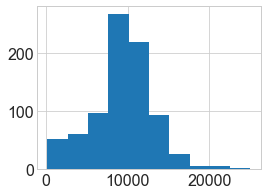

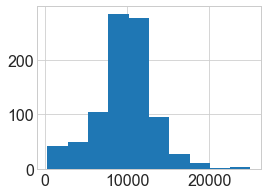

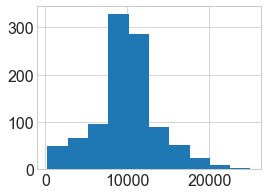

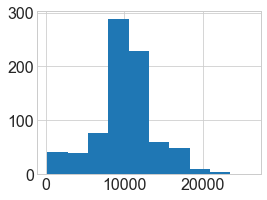

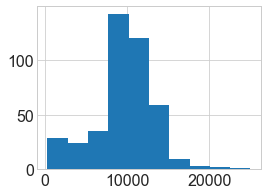

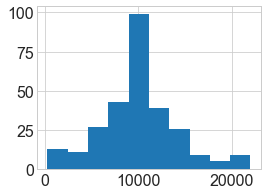

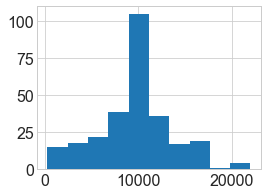

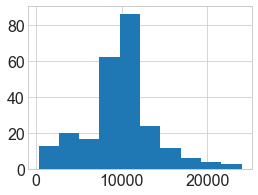

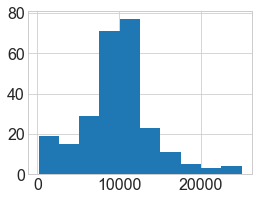

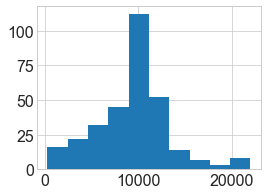

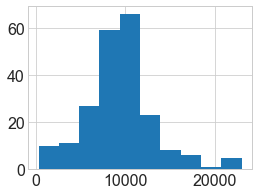

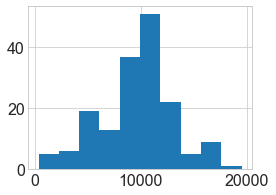

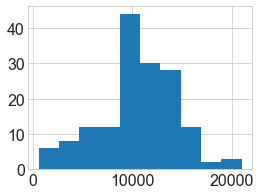

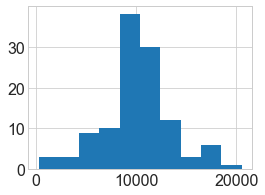

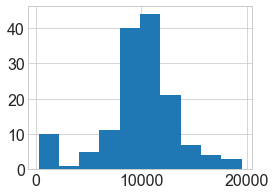

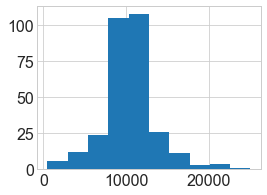

In [40]:
# plot the distributions of depth by approval time, 
# to visually check they are normally distributed
hypothesis_testing.dist_depth_by_approval_time1(train)

- These are generally normally distributed

In [41]:
# function to run kw test on approval time by depth
f, p = hypothesis_testing.kruskal_wallace1(train)
f, p

(119.62791789299312, 1.2575903447056126e-13)

In [42]:
# evaluate the results against alpha:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


- I can proceed with the understanding that there is a difference in the means of Total_depth by approval time, although a linear correlation is not evident at this time

## Does the shale formation impact approval time?

In [43]:
# the number of observations for each shale formation
train.SHALE.value_counts()

PERMIAN BASIN    23272
EAGLE FORD        8027
NONE              4071
BARNETT           1308
HAYNESVILLE       1040
Name: SHALE, dtype: int64

In [44]:
# Define the list of shale formations
shales = ['PERMIAN BASIN', 'EAGLE FORD', 'NONE', 'BARNETT', 'HAYNESVILLE']
# and print the average approval time for each
for shale in shales:
    print(train[train.SHALE == shale].Approval_time_days.mean())

6.417626332072877
7.038619658652049
6.653893392286907
6.3172782874617734
7.309615384615385


- The Barnett is fastest for approval; the Haynesville is slowest.  Stats testing here (and there is significant concern about noise in the data/limited differences between the means of the groups):

### Running a levene test to check on the variances between the populations above:

- H_0: The variances of the approval times by SHALE are the same in all populations
- H_A: The variance in the populations is different

In [45]:
# levene variance test like that run in an above cell
hypothesis_testing.levene2(train)

LeveneResult(statistic=2.2961516754377023, pvalue=0.05666758363395137)

- The null hypothesis cannot be rejected; the variances may be significantly equal

In [46]:
# double checking each variance in the following several cells
train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days.var()

31.996652042393958

In [47]:
train[train.SHALE == 'EAGLE FORD'].Approval_time_days.var()

31.46698578442854

In [48]:
train[train.SHALE == 'NONE'].Approval_time_days.var()

33.2435714471085

In [49]:
train[train.SHALE == 'BARNETT'].Approval_time_days.var()

31.168576519283413

In [50]:
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days.var()

36.985855482342664

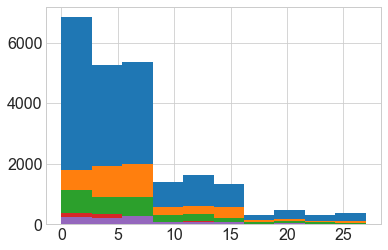

In [51]:
# a for loop to visualize the distribution approval times by shale formation
plt.figure(figsize=(6,4))
for i in [train[train.SHALE == 'PERMIAN BASIN'].Approval_time_days,
train[train.SHALE == 'EAGLE FORD'].Approval_time_days,
train[train.SHALE == 'NONE'].Approval_time_days,
train[train.SHALE == 'BARNETT'].Approval_time_days,
train[train.SHALE == 'HAYNESVILLE'].Approval_time_days]:
    i.hist()

- In addition to very similar variances, the approval times by shale are also not normally distributed

### ANOVA testing to follow (the target variable is continuous here):

- H_O: Shale is independent of the number of days to approval
- H_a: Shale plays a role in the length of time to approval

In [52]:
# running an anova test on the approval times by shale

f, p = hypothesis_testing.anova1(train)

f,p

(23.01709663829401, 5.050625333773221e-19)

- the tiny p value returned shows the null hypothesis can be rejected; proceeding with the understanding that the shale does in fact play some small role in the approval time in at least one of the shale formations

### Is there a trend over time to speak of?

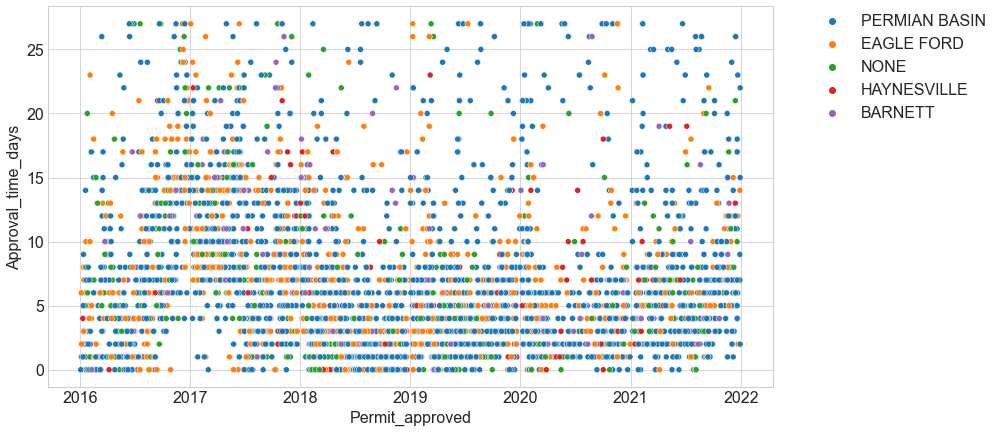

In [53]:
# create a sample to unburden the processing load for the following visual
temp = permits.sample(5000)
# a time-series type plot of approval time hued by shale
sns.scatterplot(data=temp,x=temp.index, y= 'Approval_time_days', hue = 'SHALE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)



- This visual doesn't provide a lot of clarity
- Possibly a downward trend in approval times over time

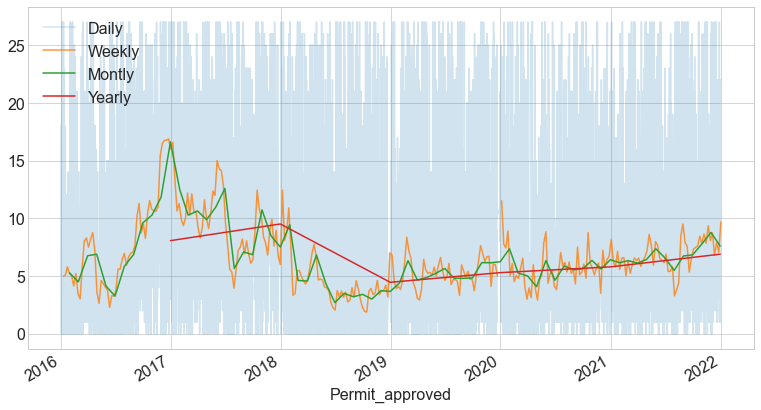

In [54]:
# a function that does a time-series plot of permit approvals over time
# note the trend lines as resampled by week, month and year
viz.tsa_resampling(train)

- There was a considerable down-tick in approval times from 2017 to 2019, after which it crept up slightly

### Is there a clear relationship between well depth and approval time?

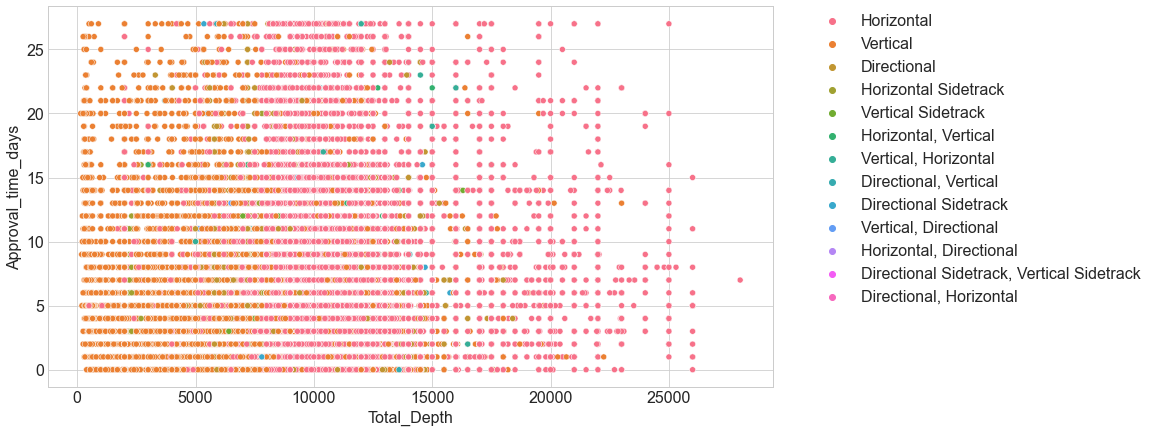

In [55]:
# A seaborn scatterplot to visualize approval time against depth
# The plot is hued on wellbore profile
sns.scatterplot(data=train,x='Total_Depth',y='Approval_time_days',hue='Wellbore_Profile')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


- There aren't so many deep well; the approval time is pretty homogeneous across the visual
- I previously established that vertical and horizontal wells dominate, by far, all wellbore profiles.
- It does look like the vertical wells tend to be somewhat shallower than the horizontal ones, and have a slightly lower approval time

In [56]:
# the average approval time for horizontal wells
train[train.Wellbore_Profile == 'Horizontal'].Approval_time_days.mean()

6.9054185656967

In [57]:
# the average approval time for vertical wells
train[train.Wellbore_Profile == 'Vertical'].Approval_time_days.mean()

5.8644196174966865

- Effectively, it can be seen here that the average approval time for horizontal wells is more than a day longer than for vertical wells

In [58]:
# the average depth for horizontal wells
train[train.Wellbore_Profile == 'Horizontal'].Total_Depth.mean()

11212.873553815589

In [59]:
# # the average depth for horizontal wells
train[train.Wellbore_Profile == 'Vertical'].Total_Depth.mean()

6808.47850785836

- And the average horizontal well is a full 4,400 feet deeper than the average vertical well.  That's 4/5ths of a mile deeper!

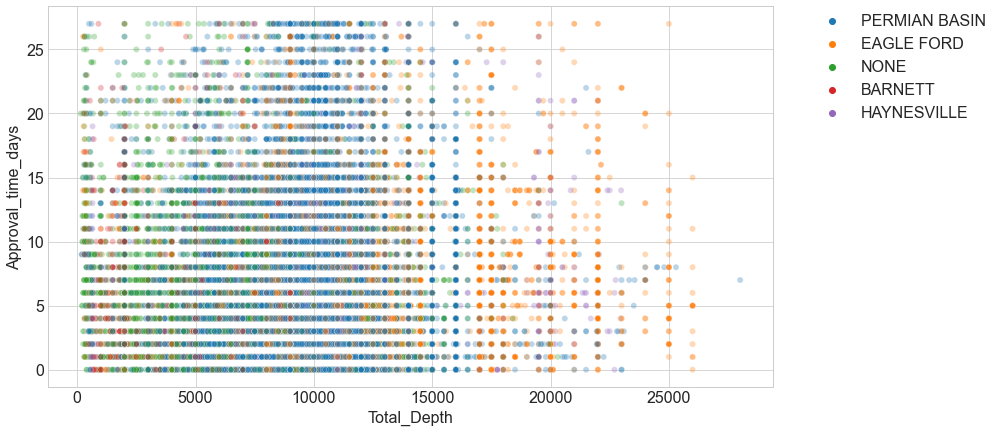

In [60]:
# a similar seaborn plot to the one above, hued on shale formation
sns.scatterplot(data=train,x='Total_Depth',y='Approval_time_days',hue='SHALE', alpha = .3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)



- Permian appears to be represented more in the middle of well depths
- Possibly fewer long approval times among the shallow wells
- The approval times, nevertheless, are pretty evenly distributed accross depths and shales

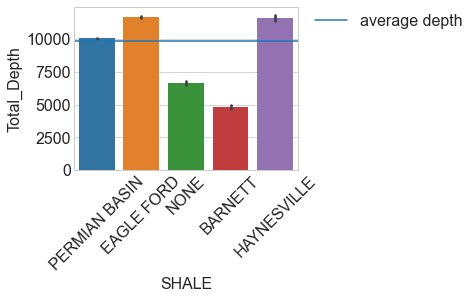

In [61]:
# a function to visualize the idea that permian wells are of average depth:
viz.shale_vs_depth(train)

- As expected, Permian approval practically define the average for depth

In [62]:
# a simple for loop function to compare the different approval times by depth bin
hypothesis_testing.depth_and_approval_time(train)

Shallow well avg approval time is 6.507404009959377
Deep well avg approval time is 6.414890257381967
Mid_depth well avg approval time is 6.96996935648621
Overall avg approval time is 6.596399597009386


- Contrary to what the visual suggested, the shallower wells do not have a below-average approval time

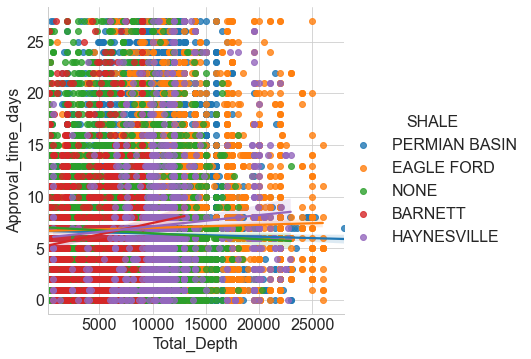

In [63]:
sns.lmplot(data=train, x= 'Total_Depth', y='Approval_time_days', hue= 'SHALE')

- The length of time for approval trends upwards as depth increases, except in the Permian Basin

## Which district is the fastest for approval?

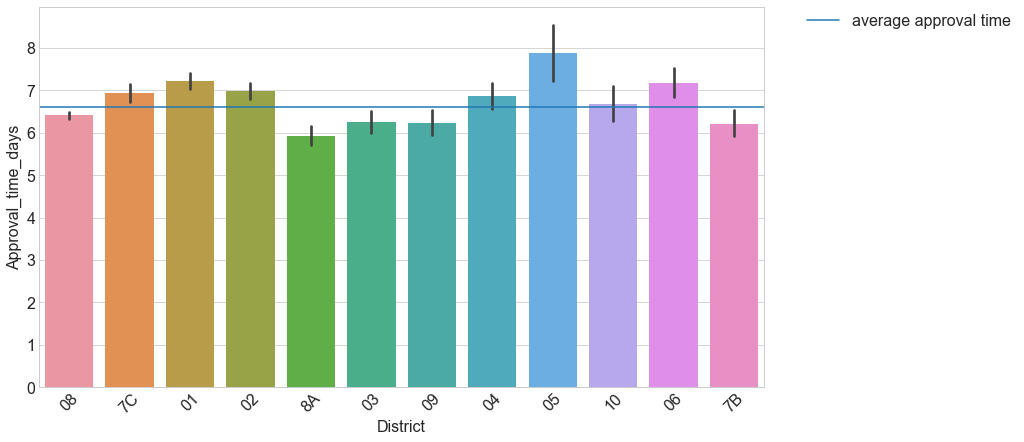

In [64]:
# self-defined function to draw a seaborn barplot of approval time by district,
# with average approval time line
viz.approval_time_by_district(train)

- Every district has a 5 or 6 day approval time; districts 5 is just barely the fastest
- On the looks of it, there doesn't seem to be evidence supporting a strong relationship here.

### Running a levene test to check on the variances between the populations above:

- H_0: The variances of the approval times by total depth are the same in all populations
- H_A: The variance in the populations is different

In [65]:
# levene variance test like that run in an above cell
hypothesis_testing.levene3(train)

LeveneResult(statistic=2.543528871674284, pvalue=0.0032697190587070183)

- The low p value signals the different variances between the districts

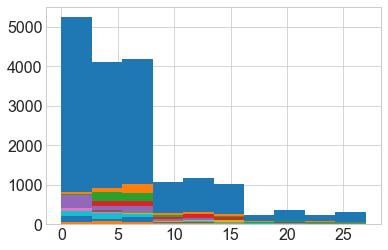

In [66]:
# a for loop to visualize the distribution approval times by district
hypothesis_testing.viz_district_approvals_distributions(train)

- This looks a lot like the distribution as done by shale

In [67]:
f, p = hypothesis_testing.anova2(train)
f, p

(15.676956033745057, 4.414654500661605e-31)

- In spite of the small differences, the takeaway is that the district does bear some impact on the approval time

# Summary: Exploration

Through a thorough visual, statistical, and common-sense exploration of the data, this study was able to demonstrate several areas where the approval time for permits is influenced by the other attributes--albeit generally to a limited extent.  Across the board, approval times were a matter of days; I was able to demonstrate a drop in permit approvals related to the beginning of the Covid pandemic as well.

Although District 8 (Midland) was far and away the busiest, it was District 5 (Kilgore) that took the longest to approve permits (again, by a small margin). The permian basin had the most permits approved, and the vast majority of permits were for new wells, of which the biggest type of well was horizontal, followed by vertical.  

The exploration found that there was some difference in the time to approval depending on well depth, and the trend is for a longer permitting time the deeper the well--with the exception of the Permian Basin, where permitting counterintuitively trends faster with depth. Vertical wells tend to be shallower, and also have a slightly faster approval time.  Still, contrary to what one visual suggested, the shallower wells do not have an overall below-average approval time (it's only on breaking down by district or shale formation that the differences become clear).

# Modeling

### Baseline

MEAN will be used as the baseline

### Features

Feature engineering will not be part of my modeling

### All the X_train/validate/test_scaled are scaled from X_train/validate/test

### X_train/validate/test_model are likewise scaled

### The model is using an unscaled target variable, and therefore the RMSE will be given in days (which is the unit of the target variable)

(array([10381.,  8609.,  8832.,  2416.,  2784.,  2222.,   557.,   815.,
          541.,   561.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

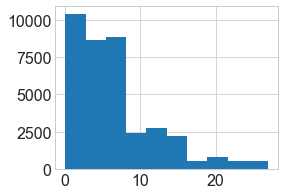

In [68]:
# visualize the distribution of y_train
plt.figure(figsize=(4,3))
plt.hist(y_train)

- Approval times are clearly not normally distributed

In [69]:
# Calculate the mean approval time of the y_train
y_train.Approval_time_days.mean()

6.596399597009386

- The above is the average approval time, i.e. the baseline for modeling

In [70]:
# Create dataframes for modeling purposes from the model module. Just dropping all 
# columns except the scaled depth and the encoded districts and shales
X_train_model, X_validate_model, X_test_model = \
model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [71]:
# add baseline prediction to all y_ dataframes using function in my model file
y_train,y_validate,y_test = model.add_pred_mean(y_train,y_validate,y_test)

In [73]:
# using a function to print the rmse of the model on train and validate, using baseline
rmse_train, rmse_validate = model.get_rmse_in_sample(y_train,y_validate)

RMSE using Mean
Train/In-Sample:  5.6746 
Validate/Out-of-Sample:  5.5954


In [75]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models
metric_df = model.create_eval_df(rmse_train, rmse_validate)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.674629,5.595407


In [77]:
# assigning and displaying the evaluation df for the various models i've run
# in my model module
metric_df = model.run_all_models(X_train_model, y_train, X_validate_model, y_validate, X_test_model, metric_df)
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,5.674629,5.595407
1,OLS Regressor,5.661146,5.586228
2,Lasso_alpha1,5.674629,5.595407
3,glm_compound,5.660915,5.585307
4,quadratic_deg2,5.652545,5.578995
5,quadratic_deg3,5.649677,5.574972


- the third degree polynomial regression is returning the best result, and will be the model used on the test dataset

### Model evaluation

In [78]:
# create polynomial features to feed into final model
X_train_degree3, X_validate_degree3, X_test_degree3 = \
model.create_polynomial_features_deg3(X_train_model, X_validate_model, X_test_model)

In [80]:
# Create the model object and print an evaluation statement for train and validate
y_test, rmse_test = \
model.create_polynomial_model_object(X_test_degree3, y_test, metric_df)
# And a statement on the RMSE of the third degree polynomial model
print("Test/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  5.649676665982054 
Validation/Out-of-Sample:  5.574971850381146
Test/Out of Sample:  5.639662829073366


In [83]:
# A simple calculation of the percent improvement over baseline:
(5.674630 - 5.639662) / 5.674630

0.006162163876763635

### Which is to say: the best model has beat baseline by 0.6 % (that's 6 tenths of one percent)

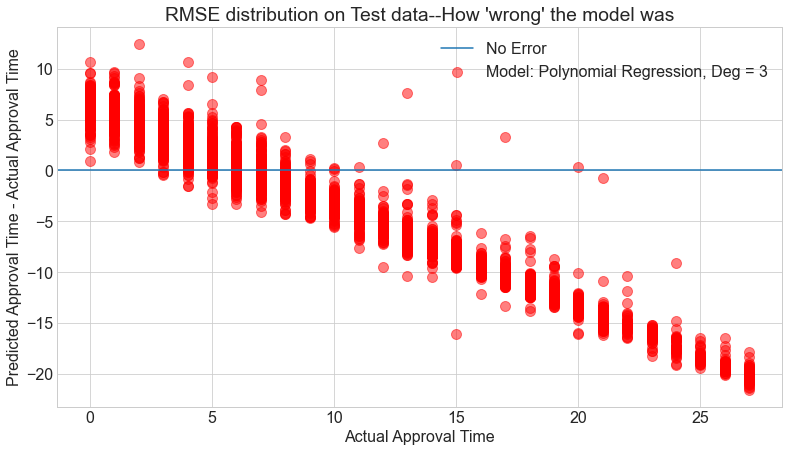

In [84]:
# A function creating a  matplotlib scatterplot 
# showing the residual error between predicted RMSE and actual tax value

model.graph_rmse_distribution(y_test)

### The graphic show how much of a difference there was between the approval time and the actual; the model gave the best results toward the lower approval times

## Conclusions

## Summary:

At the beginning of my study, I took a few high-level type questions to get a handle on the problem, and refined them as best the data allowed:
   
    - Do certain leases get approval faster? Or in certain counties/districts/shales?
    - What's the relation between well depth and shale/county/district?  Approval time? 
    - Which district approves its permits the fastest?
    
The answers to these questions remained somewhat elusive, but statistical analysis allowed some assumptions to be made--the depth of a well and its approval time do in fact have a small correlation, for example.

My model was ultimately only able to barely improve on the baseline prediction of approval time, a fact which, to this study, is evidence that permitting is being approved uniformly across the state.  I expect the model to permorm similarly on new, unseen data, as evidenced by the results on the out-of-sample data evaluated here.  

## Recommendations

For the consumer of this report, the principal actionable recommendation is to continue to keep a finger on the pulse of the TRRC's work.  It seems clear from this study that this governmental body is doing a great job when it comes to drilling permits, but the public's access to information is what allows us to make sure of it.  

In the same vein, other aspects of Texas's oil output could be presented in an easier-to-analyze fashion.  As it stands, it is difficult to do an analysis of output on a very detailed level, particularly to tie new permits to their subsequent oil and gas production (summary statistics are in fact available on the TRRC website, but are broken down to a higher level than this data science study sought).   

## Next steps

This project began in the hopes of being able to link permitting and production; this goal remains elusive, due to the structure of the data available for public download at the Texas Railroad Commision website.  However, the foremost recommendation is to continue studying ways to scrape production information in order to tie it to the permitting and producer information that is so easily available, and build on the models in this report to include a predictive model for well output based on features such as shale, depth, geography, etc.  

At the very least, finding a handfull of new continuous variables to include in the anaysis could reap benefits, since the modeling in this report relies almost exclusively on categorical variables, some of which have sparse observations to model on.  This could also increase the possibility of running some feature selection and clustering.  Clustering, in particular, was not helpful in this study--apart from all the districts already being related geographically to the areas they serve (which naturally includes the shale formation, roughly), there is only the one continuous variable to attempt to utilize for a clustering model. 

- The main next step is to continue to work on building the data up from publicly available information on the Railroad Commission website, especially information on production and geography (i.e. well latitude/longitude), items that are easily downloaded but very difficult to tie to the current database.  

Apart from the above, the following is a brief list of items that I'd like to add to future iterations of the study:

- Aggregate different lease/company names where they area obscured by sub-companies
- Split and model based on time series analysis
- Remove those counties and districts with particularly few observations
- Run a feature selection algorithm